### This notebook contains attention roll visualisation for analyses on negation, temporal order and lexical overlap

In [ ]:
import math
import numpy as np
import torch
from torch import nn, dtype
import torch.nn.functional as F
from torch.optim import Optimizer
from torch.utils.data import random_split, DataLoader, Dataset
from config import PretrainedConfig, GPT2Config
from transformers import GPT2Model as OpenAIGPT2Model
from transformers import GPT2Tokenizer
from utils import *
from einops import rearrange
from typing import Callable, Iterable, Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
text = "Welcome, this is the beginning of default final project!"
input_ids = tokenizer(text)['input_ids']
print('input_ids:', input_ids)
for token in input_ids:
    print('token', tokenizer.decode(token))

input_ids: [14618, 11, 428, 318, 262, 3726, 286, 4277, 2457, 1628, 0]
token Welcome
token ,
token  this
token  is
token  the
token  beginning
token  of
token  default
token  final
token  project
token !


In [ ]:
class CausalSelfAttention(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.num_attention_heads = config.num_attention_heads
    self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
    self.all_head_size = self.num_attention_heads * self.attention_head_size

    # Initialize the linear transformation layers for key, value, query.
    self.query = nn.Linear(config.hidden_size, self.all_head_size)
    self.key = nn.Linear(config.hidden_size, self.all_head_size)
    self.value = nn.Linear(config.hidden_size, self.all_head_size)
    # This dropout is applied to normalized attention scores following the original
    # implementation of transformer. Although it is a bit unusual, we empirically
    # observe that it yields better performance.
    self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

  def transform(self, x, linear_layer):
    # The corresponding linear_layer of k, v, q are used to project the hidden_state (x).
    proj = linear_layer(x)
    # Next, we need to produce multiple heads for the proj. This is done by spliting the
    # hidden state to self.num_attention_heads, each of size self.attention_head_size.
    proj = rearrange(proj, 'b t (h d) -> b t h d', h=self.num_attention_heads)
    # By proper transpose, we have proj of size [bs, num_attention_heads, seq_len, attention_head_size].
    proj = rearrange(proj, 'b t h d -> b h t d')
    return proj

  def attention(self, key, query, value, attention_mask, output_attentions=False,head_mask=None):
    """
    TODO-1: Compute scaled dot-product attention for GPT-2.

    Implementation hints:
    1. Compute raw attention scores using QK^T, and scale them by sqrt(d_k).
    2. Apply a causal mask (lower-triangular) to prevent attending to future tokens.
    3. Optionally add the external attention_mask (e.g., padding positions).
    4. Normalize the scores with softmax to obtain attention probabilities.
    5. Apply dropout on the probabilities.
    6. Use them to weight the values (V) and obtain the context vectors.
    7. Finally, merge all attention heads back into a single hidden representation.
    """
    ### YOUR CODE HERE
    #query=(num_queries,d_k)
    #compute raw attention scores
    attention_scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.attention_head_size)
    #apply causal mask
    #create the lower triangular matrix
    seq_len = attention_scores.size(-1)
    causal_mask = torch.tril(torch.ones((seq_len, seq_len), device=attention_scores.device))
    causal_mask = causal_mask.unsqueeze(0).unsqueeze(0) #add batch and head dimensions
    #apply mask, set positions with 0 to -inf
    attention_scores = attention_scores.masked_fill(causal_mask == 0, -1e9)
    #add external attention mask
    if attention_mask is not None:
      attention_scores = attention_scores + attention_mask

    if head_mask is not None:
        attention_probs = attention_probs * head_mask.view(1, -1, 1, 1)
    
    #normalize scores with softmax
    attention_probs = torch.softmax(attention_scores, dim=-1)
    #visualisation of attention probs
    attention_probs_visualisation = attention_probs.clone() if output_attentions else None
  
    #apply dropout
    attention_probs = self.dropout(attention_probs)
    #weigh the values(attention_prob@value)
    context_vector=torch.matmul(attention_probs,value)
    #merge all attention heads into 1
    batch_size, num_heads, seq_len, head_size = context_vector.size()
    context = context_vector.transpose(1, 2).contiguous().reshape(batch_size, seq_len, num_heads * head_size)

    if output_attentions:
      return context, attention_probs_visualisation

    return context


  def forward(self, hidden_states, attention_mask,output_attentions=False, head_mask=None):
    """
    hidden_states: [bs, seq_len, hidden_state]
    attention_mask: [bs, 1, 1, seq_len]
    output: [bs, seq_len, hidden_state]
    """
    # First, we have to generate the key, value, query for each token for multi-head attention
    # using self.transform (more details inside the function).
    # Size of *_layer is [bs, num_attention_heads, seq_len, attention_head_size].
    key_layer = self.transform(hidden_states, self.key)
    value_layer = self.transform(hidden_states, self.value)
    query_layer = self.transform(hidden_states, self.query)
    
    if output_attentions: 
      attn_value, attn_weights = self.attention(key_layer,query_layer,value_layer,attention_mask,output_attentions=True,head_mask=head_mask)
      return attn_value,attn_weights
    # Calculate the multi-head attention using the self.attention function.
    attn_value = self.attention(key_layer, query_layer, value_layer, attention_mask,head_mask=head_mask)
    return attn_value

In [ ]:
class GPT2Layer(nn.Module):
  def __init__(self, config):
    super().__init__()
    # Multi-head attention.
    self.self_attention = CausalSelfAttention(config)
    # Add-norm for multi-head attention.
    self.attention_dense = nn.Linear(config.hidden_size, config.hidden_size)
    self.attention_layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
    self.attention_dropout = nn.Dropout(config.hidden_dropout_prob)
    # Feed forward.
    self.interm_dense = nn.Linear(config.hidden_size, config.intermediate_size)
    self.interm_af = F.gelu
    # Add-norm for feed forward.
    self.out_dense = nn.Linear(config.intermediate_size, config.hidden_size)
    self.out_layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
    self.out_dropout = nn.Dropout(config.hidden_dropout_prob)

  def add(self, input, output, dense_layer, dropout):
    """
    TODO-2: Residual connection with dense projection and dropout.
    
    Implementation hints:
    1. Project the 'output' through dense_layer.
    2. Apply dropout to prevent overfitting.
    3. Add the original 'input' (residual connection) to the processed output.
    """

    ### YOUR CODE HERE
    #project output through dense_layer
    projected=dense_layer(output)
    #apply dropout
    projected=dropout(projected)
    #add OG input to output
    return input+projected


  def forward(self, hidden_states, attention_mask, output_attentions=False, head_mask=None):
    """
    TODO-3: Forward pass of a GPT-2 layer.

    Implementation hints:
    ---- Self-Attention Block ----
    1. LayerNorm the input for stability using self.attention_layer_norm.
    2. Compute multi-head causal self-attention using self.self_attention.
    3. Apply residual connection using self.add (dense_layer=self.attention_dense, dropout=self.attention_dropout).

    ---- Feed Forward Block ----
    4. LayerNorm the hidden_states from attention block using self.out_layer_norm.
    5. Pass through a two-layer feed-forward network with activation:
       self.interm_dense -> self.interm_af -> self.out_dense
    6. Apply residual connection again using self.add (dense_layer=self.out_dense, dropout=self.out_dropout).
    """
    ### YOUR CODE HERE
    #1. layernorm the input
    normed_input=self.attention_layer_norm(hidden_states)

    if output_attentions:
      attn_output, attn_weights = self.self_attention(normed_input, attention_mask, output_attentions = True, head_mask=head_mask)
    else:
      attn_output = self.self_attention(normed_input,attention_mask, head_mask=head_mask)
      attn_weights = None
    #2. compute the self attention
    # attn_output=self.self_attention(normed_input,attention_mask)
    #3. apply residual connection
    hidden_states=self.add(hidden_states,attn_output,self.attention_dense,self.attention_dropout)
    #4. layernorm the hidden states from attention blocks
    normed_ff=self.out_layer_norm(hidden_states)
    #5. pass through 2 layer feed forward
    ff_output=self.interm_dense(normed_ff)
    ff_output=self.interm_af(ff_output)
    # ff_output = self.out_dense(ff_output)
    # ff_output = self.out_dropout(ff_output)
    hidden_states = self.add(hidden_states,ff_output, self.out_dense, self.out_dropout)
    #6. apply residual connection
    # #6. apply residual connection
    # hidden_states = hidden_states + ff_output
    if output_attentions: 
      return hidden_states, attn_weights
    return hidden_states

In [ ]:
class GPTPreTrainedModel(nn.Module):

  def __init__(self, config: PretrainedConfig, *inputs, **kwargs):
    super().__init__()
    self.config = config
    self.name_or_path = config.name_or_path

  def init_weights(self):
    # Initialize weights
    self.apply(self._init_weights)

  def _init_weights(self, module):
    """ Initialize the weights """
    if isinstance(module, (nn.Linear, nn.Embedding)):
      # Slightly different from the TF version which uses truncated_normal for initialization
      # cf https://github.com/pytorch/pytorch/pull/5617
      module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
    elif isinstance(module, nn.LayerNorm):
      module.bias.data.zero_()
      module.weight.data.fill_(1.0)
    if isinstance(module, nn.Linear) and module.bias is not None:
      module.bias.data.zero_()

  @property
  def dtype(self) -> dtype:
    return get_parameter_dtype(self)

In [ ]:
class GPT2Model(GPTPreTrainedModel):
  """
  The GPT model returns the final embeddings for each token in a sentence.

  The model consists of:
  1. Embedding layers (used in self.embed).
  2. A stack of n GPT layers (used in self.encode).
  3. A linear transformation layer for the [CLS] token (used in self.forward, as given).
  """

  def __init__(self, config):
    super().__init__(config)
    self.config = config

    # Embedding layers.
    self.word_embedding = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
    self.pos_embedding = nn.Embedding(config.max_position_embeddings, config.hidden_size)
    self.embed_dropout = nn.Dropout(config.hidden_dropout_prob)

    # Register position_ids (1, len position emb) to buffer because it is a constant.
    position_ids = torch.arange(config.max_position_embeddings).unsqueeze(0)
    self.register_buffer('position_ids', position_ids)

    # GPT-2 layers.
    self.gpt_layers = nn.ModuleList([GPT2Layer(config) for _ in range(config.num_hidden_layers)])

    # [CLS] token transformations.
    self.pooler_dense = nn.Linear(config.hidden_size, config.hidden_size)
    self.pooler_af = nn.Tanh()

    # Final layer norm.
    self.final_layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    self.init_weights()

  def embed(self, input_ids):
    """
    TODO-4: Embedding layer of the GPT-2 model.

    Implementation hints:
    1. Use self.word_embedding to convert input_ids to embeddings.
    2. Generate position ids and convert to embeddings using self.pos_embedding.
    3. Sum token and position embeddings.
    4. Apply self.embed_dropout to the sum.
    """
    ### YOUR CODE HERE
    #get token embeddings
    token_embeddings=self.word_embedding(input_ids)
    batch_size, seq_len = input_ids.size()
    #generate position ids and convert to embeddings
    position_ids = self.position_ids[:, :seq_len]
    position_ids = position_ids.expand(batch_size, seq_len)
    position_embeddings = self.pos_embedding(position_ids)
    #sum token and position embeddings
    sum_of_embeddings=token_embeddings+position_embeddings
    sum_of_embeddings=self.embed_dropout(sum_of_embeddings)
    return sum_of_embeddings

  def encode(self, hidden_states, attention_mask, output_attentions=False, output_hidden_states = False, head_mask=None):
    """
    hidden_states: the output from the embedding layer [batch_size, seq_len, hidden_size]
    attention_mask: [batch_size, seq_len]
    """
    # Get the extended attention mask for self-attention.
    # Returns extended_attention_mask of size [batch_size, 1, 1, seq_len].
    # Distinguishes between non-padding tokens (with a value of 0) and padding tokens
    # (with a value of a large negative number).
    extended_attention_mask: torch.Tensor = get_extended_attention_mask(attention_mask, self.dtype)
    all_hidden_states = [] if output_hidden_states else None
    all_attentions = [] if output_attentions else None
    # Pass the hidden states through the encoder layers.
    for i, layer_module in enumerate(self.gpt_layers):
      if output_hidden_states:
        all_hidden_states.append(hidden_states)
      layer_head_mask = head_mask[i] if head_mask is not None else None
      if output_attentions:
        hidden_states , attn_weights = layer_module(hidden_states, extended_attention_mask, output_attentions = True, head_mask=layer_head_mask )
        all_attentions.append(attn_weights)
      else:
        # Feed the encoding from the last bert_layer to the next.
        hidden_states = layer_module(hidden_states, extended_attention_mask, head_mask=layer_head_mask)
    if output_hidden_states:
      all_hidden_states.append(hidden_states)
    outputs = {'hidden_states': hidden_states}
    if output_attentions:
      outputs['attentions']= all_attentions
    if output_hidden_states: 
      outputs['all_hidden_states']= all_hidden_states

    return outputs

  def get_extended_attention_mask(self, attention_mask):
      """Helper to create extended attention mask"""
      if attention_mask.dim() == 2:
          extended_attention_mask = attention_mask[:, None, None, :]
      else:
          extended_attention_mask = attention_mask
      extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
      extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
      return extended_attention_mask
  
  def forward(self, input_ids, attention_mask, output_attentions=False, output_hidden_states =False,  head_mask=None):
    """
    input_ids: [batch_size, seq_len], seq_len is the max length of the batch
    attention_mask: same size as input_ids, 1 represents non-padding tokens, 0 represents padding tokens
    """
    # Get the embedding for each input token.
    embedding_output = self.embed(input_ids=input_ids)

    # Feed to a transformer (a stack of GPTLayers).
    encode_outputs = self.encode(embedding_output, attention_mask=attention_mask, output_attentions= output_attentions, output_hidden_states = output_hidden_states, head_mask=head_mask)
    sequence_output = encode_outputs['hidden_states']
    sequence_output = self.final_layer_norm(sequence_output)

    # Get the hidden state of the final token.
    last_non_pad_idx = attention_mask.sum(dim=1) - 1  # Subtract 1 to get last index
    last_token = sequence_output[torch.arange(sequence_output.shape[0]), last_non_pad_idx]

    outputs = {
            'last_hidden_state': sequence_output,
            'last_token': last_token
        }
        
    if output_attentions:
        outputs['attentions'] = encode_outputs['attentions']
    if output_hidden_states:
        outputs['all_hidden_states'] = encode_outputs['all_hidden_states']
        
    return outputs
    # return {'last_hidden_state': sequence_output, 'last_token': last_token}

  def hidden_state_to_token(self, hidden_state):
    """
    TODO-5: Convert hidden states back to token logits.

    Implementation hints: 
    - GPT-2 uses weight tying with the input word embeddings. 
    - The logits are the dot product between output hidden states and the word embedding weights: hidden_state(s) * E^T
    """
    ### YOUR CODE HERE
    logits = torch.matmul(hidden_state, self.word_embedding.weight.T)
    return logits

  @classmethod
  def from_pretrained(cls, model='gpt2', d=768, l=12, num_heads=12):
    gpt_model = OpenAIGPT2Model.from_pretrained(model).eval()
    our_model = GPT2Model(GPT2Config(hidden_size=d, num_hidden_layers=l,num_attention_heads=num_heads,
                                     intermediate_size=d*3)).eval()

    # Load word and positional embeddings.
    our_model.word_embedding.load_state_dict(gpt_model.wte.state_dict())
    our_model.pos_embedding.load_state_dict(gpt_model.wpe.state_dict())

    for i in range(l):
      l = our_model.gpt_layers[i]
      # Remap the Q,K,V weights from a conv1d to 3 linear projections
      l.self_attention.query.weight.data = gpt_model.state_dict()[f'h.{i}.attn.c_attn.weight'][:, :d].T
      l.self_attention.query.bias.data = gpt_model.state_dict()[f'h.{i}.attn.c_attn.bias'][:d]
      l.self_attention.key.weight.data = gpt_model.state_dict()[f'h.{i}.attn.c_attn.weight'][:, d:d*2].T
      l.self_attention.key.bias.data = gpt_model.state_dict()[f'h.{i}.attn.c_attn.bias'][d:d*2]
      l.self_attention.value.weight.data = gpt_model.state_dict()[f'h.{i}.attn.c_attn.weight'][:, d*2:].T
      l.self_attention.value.bias.data = gpt_model.state_dict()[f'h.{i}.attn.c_attn.bias'][d*2:]

      # Remap final dense layer in MHA.
      l.attention_dense.weight.data = gpt_model.state_dict()[f'h.{i}.attn.c_proj.weight'].T
      l.attention_dense.bias.data = gpt_model.state_dict()[f'h.{i}.attn.c_proj.bias']

      # Remap attention layer norm.
      l.attention_layer_norm.weight.data = gpt_model.state_dict()[f'h.{i}.ln_1.weight']
      l.attention_layer_norm.bias.data = gpt_model.state_dict()[f'h.{i}.ln_1.bias']

      # Remap post-attention MLP layers.
      l.interm_dense.weight.data = gpt_model.state_dict()[f'h.{i}.mlp.c_fc.weight'].T
      l.interm_dense.bias.data = gpt_model.state_dict()[f'h.{i}.mlp.c_fc.bias']
      l.out_dense.weight.data = gpt_model.state_dict()[f'h.{i}.mlp.c_proj.weight'].T
      l.out_dense.bias.data = gpt_model.state_dict()[f'h.{i}.mlp.c_proj.bias']

      # Remap second layer norm weights.
      l.out_layer_norm.weight.data = gpt_model.state_dict()[f'h.{i}.ln_2.weight']
      l.out_layer_norm.bias.data = gpt_model.state_dict()[f'h.{i}.ln_2.bias']

    # Remap the final layer norm values.
    our_model.final_layer_norm.weight.data = gpt_model.state_dict()['ln_f.weight']
    our_model.final_layer_norm.bias.data = gpt_model.state_dict()['ln_f.bias']

    return our_model

In [ ]:
class AdamW(Optimizer):
    def __init__(
            self,
            params: Iterable[torch.nn.parameter.Parameter],
            lr: float = 1e-3,
            betas: Tuple[float, float] = (0.9, 0.999),
            eps: float = 1e-6,
            weight_decay: float = 0.0,
            correct_bias: bool = True,
    ):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[1]))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {} - should be >= 0.0".format(eps))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, correct_bias=correct_bias)
        super().__init__(params, defaults)

    def step(self, closure: Callable = None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")

                # State should be stored in this dictionary.
                state = self.state[p]

                # Access hyperparameters from the `group` dictionary.
                lr = group["lr"]
                eps = group["eps"]
                weight_decay = group["weight_decay"]
                correct_bias = group["correct_bias"]
                beta1, beta2 = group["betas"]
                state = self.state[p]
                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p.data)
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                
                state["step"] += 1
                t = state["step"]
                
                """
                TODO-6: Implement the AdamW parameter update for this step.

                Implementation hints:
                1. Update biased first moment estimate:
                    m_t = beta1 * m_{t-1} + (1 - beta1) * grad
                2. Update biased second raw moment estimate:
                    v_t = beta2 * v_{t-1} + (1 - beta2) * grad^2
                3. Apply bias correction if correct_bias=True:
                    m_hat = m_t / (1 - beta1^t)
                    v_hat = v_t / (1 - beta2^t)
                4. Compute step size:
                    step_size = lr (or lr / (1 - beta1^t) if bias correction)
                5. Update parameters:
                    p = p - step_size * m_hat / (sqrt(v_hat) + eps)
                6. Apply decoupled weight decay after the parameter update (if weight_decay > 0):
                    p = p - lr * weight_decay * p
                Reference:
                Algorithm 1 in "Adam: A Method for Stochastic Optimization"
                https://arxiv.org/abs/1412.6980
                """
                ### YOUR CODE HERE
                exp_avg = state["exp_avg"]
                exp_avg_sq = state["exp_avg_sq"]

                # update biased first and second moments
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # bias correction
                if correct_bias:
                    m_hat = exp_avg / (1 - beta1 ** t)
                    v_hat = exp_avg_sq / (1 - beta2 ** t)
                else:
                    m_hat = exp_avg
                    v_hat = exp_avg_sq

                # update p
                p.data.addcdiv_(-lr, m_hat, torch.sqrt(v_hat) + eps)

                # apply weight decay
                if weight_decay > 0:
                    p.data.add_(-lr * weight_decay, p.data)
        return loss

In [ ]:
@torch.no_grad()
def generate_gpt2(model, tokenizer, input_ids, max_gen_length=50, device="cuda"):
    """
    Generate text from a GPT-2 model given a single input sequence (greedy decoding).

    Note:
        - Currently only supports batch_size=1 (single input sequence).
        - Using greedy decoding, so each run with the same input produces the same output.
        - Other sampling-based decoding methods (e.g., top-k, top-p, temperature) can introduce randomness and yield different outputs each run.

    Args:
        model: GPT-2 model (pretrained or fine-tuned)
        tokenizer: GPT-2 tokenizer
        input_ids: torch.LongTensor of shape [1, seq_len], input token IDs
        max_gen_length: int, maximum number of tokens to generate
        device: str, "cuda" or "cpu"

    Returns:
        str: Generated text
    """
    model.eval()
    input_ids = input_ids.to(device)  # move input to device
    output_ids = input_ids.clone()

    """
    TODO-8: Greedy next-token generation loop

    Implementation hints:
    Repeat the below steps up to max_gen_length:
    1. Construct an attention mask based on current output_ids (non-pad tokens).
    2. Pass output_ids and attention_mask through the model to get hidden states.
    3. Convert the last hidden state to logits over the vocabulary using model.hidden_state_to_token.
    4. Select the next token using greedy decoding (argmax over logits).
    5. Append the next token to output_ids.
    6. Stop the loop early if the EOS token is generated.
    
    """
    ### YOUR CODE HERE
    for _ in range(max_gen_length):
        attention_mask=torch.ones_like(output_ids)
        hidden_states=model(output_ids,attention_mask) #hidden state is a dictionary w keys last_hidden_state and last_token
        # print(type(hidden_states))
        # print(hidden_states.keys() if hasattr(hidden_states, 'keys') else hidden_states)
        last_hidden = hidden_states['last_hidden_state'][:, -1, :] #shape : [batch_size, sequence_length, hidden_dim]
        logits = model.hidden_state_to_token(last_hidden)
        next_token = torch.argmax(logits,dim=-1).unsqueeze(-1)
        output_ids = torch.cat([output_ids, next_token],dim=-1)
        if (next_token == tokenizer.eos_token_id).any():
            break

    # raise NotImplementedError

    # Decode generated tokens to string
    ids = output_ids[0]
    text = tokenizer.decode(ids, skip_special_tokens=True)

    return text

In [ ]:
class NLI_visualisation:
    def __init__(self,model,tokenizer, device='cpu'):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.model = self.model.to(self.device) 
        self.model.eval()

    def extract_attention(self,premise,hypothesis):
        """
        Extract attention weights for p-h pair
        Returns:
            tokens: list of token string
            attentions : list of attention tensors [num_heads,seq_len,seq_len]
        """
        text = f'{premise} [SEP] {hypothesis}'
        inputs = self.tokenizer(text, return_tensors='pt', padding=False,truncation=True)
        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)

        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])

        with torch.no_grad():
            outputs = self.model(input_ids = input_ids, attention_mask = attention_mask, output_attentions = True)
        attentions = [attn[0].cpu() for attn in outputs['attentions']] #batch index 0, because only processed one sentence pair
        return tokens,attentions
    
    def extract_hidden_states(self, texts, labels=None):
        """
        Extract hidden states from all layers for a batch of texts
        Returns:
            all_hidden_states: list of tensors [batch, seq_len, hidden_dim] for each layer
            labels: optional labels for the texts
        """
        inputs = self.tokenizer(texts, return_tensors='pt', padding=True, 
                               truncation=True, max_length=512)
        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)
        
        with torch.no_grad():
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True
            )
        
        #get last token representations for each layer
        all_hidden_states = outputs['all_hidden_states']
        
        #extract last non padding token for each sequence
        last_hidden_per_layer = []
        for layer_hidden in all_hidden_states:
            last_non_pad_idx = attention_mask.sum(dim=1) - 1
            last_tokens = layer_hidden[torch.arange(layer_hidden.shape[0]), last_non_pad_idx]
            last_hidden_per_layer.append(last_tokens.cpu())
        
        return last_hidden_per_layer, labels


    #     return attn_matrix
    def visualise_attention_head(self,premise,hypothesis,layer=0,head=0,figsize=(12,10),mode="tokens",event_spans=None):
        """
        Visualise attention head.
        mode="tokens": normal token-level heatmap (your original version)
        mode="events": collapsed event-level temporal heatmap
        """

        tokens, attentions = self.extract_attention(premise, hypothesis)
        attn_matrix = attentions[layer][head].numpy()

        if mode == "tokens":
            plt.figure(figsize=figsize)
            sns.heatmap(attn_matrix,xticklabels=tokens,yticklabels=tokens,cmap='viridis',cbar_kws={'label': 'Attention weights'})
            plt.title(f'Layer {layer}, Head {head}\nPremise: {premise}\nHypothesis: {hypothesis}')
            plt.xlabel('Key tokens')
            plt.ylabel('Query tokens')
            plt.tight_layout()
            plt.show()
            return attn_matrix

        elif mode == "events":
            assert event_spans is not None, "You must provide event_spans for mode='events'"

            token_to_event = []
            for tok in tokens:
                found_event = None
                for event_name, span_tokens in event_spans.items():
                    if any(st.lower() in tok.lower() for st in span_tokens):
                        found_event = event_name
                token_to_event.append(found_event)

            events = list(event_spans.keys())

            # build event-level matrix
            E = len(events)
            event_attn = np.zeros((E, E))

            # index lookup
            event_indices = {
                e: [i for i, ev in enumerate(token_to_event) if ev == e]
                for e in events
            }

            for i, e1 in enumerate(events):
                for j, e2 in enumerate(events):
                    idx1 = event_indices[e1]
                    idx2 = event_indices[e2]
                    if idx1 and idx2:
                        sub = attn_matrix[np.ix_(idx1, idx2)]
                        event_attn[i, j] = sub.mean()

            # plot event-level map
            plt.figure(figsize=(8,7))
            sns.heatmap(event_attn,
                        xticklabels=events,
                        yticklabels=events,
                        cmap='viridis',
                        annot=True)
            plt.title(f'Event-Level Attention\nLayer {layer}, Head {head}')
            plt.show()

            return event_attn

    def find_lexical_overlap_heads(self, premise, hypothesis):
        """
        Identify attention heads that primarily focus on lexically overlapping words.
        This exposes the lexical overlap heuristic weakness.
        """
        tokens, attentions = self.extract_attention(premise, hypothesis)
        
        # Find premise and hypothesis boundaries
        sep_idx = tokens.index('[SEP]') if '[SEP]' in tokens else len(tokens) // 2
        premise_tokens = set(tokens[:sep_idx])
        hypothesis_tokens = set(tokens[sep_idx+1:])
        overlapping_tokens = premise_tokens & hypothesis_tokens
        
        # Find positions of overlapping tokens
        overlap_positions = [i for i, tok in enumerate(tokens) if tok in overlapping_tokens]
        
        results = []
        for layer_idx, attn in enumerate(attentions):
            num_heads = attn.shape[0]
            for head_idx in range(num_heads):
                attn_head = attn[head_idx].numpy()
                
                # Calculate what fraction of attention goes to overlapping words
                if len(overlap_positions) > 0:
                    overlap_attn = attn_head[:, overlap_positions].sum() / attn_head.sum()
                else:
                    overlap_attn = 0
                
                results.append({
                    'layer': layer_idx,
                    'head': head_idx,
                    'overlap_attention_ratio': overlap_attn
                })
        
        df = pd.DataFrame(results)
 
        plt.figure(figsize=(12, 8))
        pivot = df.pivot(index='layer', columns='head', values='overlap_attention_ratio')
        sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlOrRd', 
                   cbar_kws={'label': 'Overlap Attention Ratio'})
        plt.title(f'Lexical Overlap Attention Heatmap\nPremise: {premise}\nHypothesis: {hypothesis}')
        plt.xlabel('Head')
        plt.ylabel('Layer')
        plt.tight_layout()
        plt.show()
        
        return df
    def find_top_coref_heads(self, coref_examples, pronouns=None):
        """
        Find attention heads that specialize in coreference.
        coref_examples format:
            [
                {
                    "premise": "...",
                    "hypothesis_correct": "...",
                    "hypothesis_incorrect": "...",
                    "pronoun": "he",
                    "antecedent_correct": "lawyer",
                    "antecedent_wrong": "doctor"
                },
                ...
            ]

        Returns:
            sorted list of (score, layer, head)
        """

        if pronouns is None:
            pronouns = ["he", "she", "his", "her", "they", "them", "their"]

        num_layers = self.model.config.num_hidden_layers
        num_heads = self.model.config.num_attention_heads

        # score accumulator
        head_scores = np.zeros((num_layers, num_heads))
        example_count = 0

        for ex in coref_examples:
            example_count += 1

            # extract for correct hypothesis
            tokens_c, attn_c = self.extract_attention(ex["premise"],ex["hypothesis_correct"])
            # extract for incorrect hypothesis
            tokens_w, attn_w = self.extract_attention(ex["premise"],ex["hypothesis_incorrect"])
            # find pronoun position
            pron = ex["pronoun"].lower()
            pron_positions = [i for i, tok in enumerate(tokens_c) if pron in tok.lower()]
            if not pron_positions:
                continue
            p = pron_positions[0]  # just take first pronoun occurrence

            # correct antecedent
            ant_c = ex["antecedent_correct"].lower()
            pos_cands_c = [i for i, tok in enumerate(tokens_c) if ant_c in tok.lower()]
            if not pos_cands_c:
                continue
            a_c = pos_cands_c[0]

            # wrong antecedent
            ant_w = ex["antecedent_wrong"].lower()
            pos_cands_w = [i for i, tok in enumerate(tokens_w) if ant_w in tok.lower()]
            if not pos_cands_w:
                continue
            a_w = pos_cands_w[0]

            # compute score per layer/head
            for layer in range(num_layers):
                for head in range(num_heads):
                    # attention matrices (seq, seq)
                    A_c = attn_c[layer][head].numpy()
                    A_w = attn_w[layer][head].numpy()

                    # pronoun→ante attention
                    attn_to_correct = A_c[p][a_c]
                    attn_to_wrong   = A_w[p][a_w]

                    # score = correct - wrong
                    head_scores[layer, head] += (attn_to_correct - attn_to_wrong)

        # average over examples
        head_scores /= max(1, example_count)

        # flatten into list of tuples
        scores_list = []
        for L in range(num_layers):
            for H in range(num_heads):
                scores_list.append((head_scores[L, H], L, H))

        # sort by descending score
        scores_list.sort(reverse=True)

        return scores_list


      
    def find_top_negation_heads(self, examples, negation_words=None):
        """
        Find attention heads that specialize in negation with statistical validation.
        
        Args:
            examples: list of dicts with structure:
                [
                    {
                        "premise": "The movie was not good",
                        "hypothesis": "The movie was bad"
                    },
                    ...
                ]
            negation_words: list of negation words to look for (optional)
        
        Returns:
            results_df_to: DataFrame with statistics for attention TO negation
            results_df_from: DataFrame with statistics for attention FROM negation
            top_to: sorted list of (score, layer, head) tuples
            top_from: sorted list of (score, layer, head) tuples
        """
        
        if negation_words is None:
            negation_words = ["not", "never", "no", "none", "n't", "nothing", "nobody"]
        
        num_layers = self.model.config.num_hidden_layers
        num_heads = self.model.config.num_attention_heads
        
        # Store scores for each head across all examples
        head_to_neg_scores = {(layer, head): [] for layer in range(num_layers) for head in range(num_heads)}
        head_from_neg_scores = {(layer, head): [] for layer in range(num_layers) for head in range(num_heads)}
        examples_processed = 0
        
        for ex in examples:
            #extract attention for this example
            tokens, attentions = self.extract_attention(ex["premise"], ex["hypothesis"])
            #find negation positions
            neg_positions = []
            for i, tok in enumerate(tokens):
                tok_clean = tok.lower().replace('##', '').replace('Ġ', '').strip()
                #check single token
                if any(neg in tok_clean for neg in negation_words):
                    neg_positions.append(i)
                # check combined tokens (e.g., "did" + "n't")
                if i < len(tokens) - 1:
                    next_tok = tokens[i + 1].lower().replace('##', '').replace('Ġ', '').strip()
                    combined = tok_clean + next_tok
                    if any(neg in combined for neg in negation_words):
                        neg_positions.extend([i, i + 1])
            
            #remove duplicates and sort
            neg_positions = sorted(set(neg_positions))
            
            if not neg_positions:
                print(f"Warning: No negation found in: {tokens[:10]}...")
                continue
            
            examples_processed += 1
            baseline = 1.0 / len(tokens)
            
            # For each layer and head, compute attention differences from baseline
            for layer_idx, attn in enumerate(attentions):
                for head_idx in range(attn.shape[0]):
                    head_attn = attn[head_idx].numpy()
                    
                    #attention TO negation (column-wise) - difference from baseline
                    to_neg = head_attn[:, neg_positions].mean() - baseline
                    
                    #attention FROM negation (row-wise) - difference from baseline
                    from_neg = head_attn[neg_positions, :].mean() - baseline
                    
                    head_to_neg_scores[(layer_idx, head_idx)].append(to_neg)
                    head_from_neg_scores[(layer_idx, head_idx)].append(from_neg)
        
        print(f"Processed {examples_processed} examples")
        
        if examples_processed == 0:
            print("ERROR: No examples with negation were found!")
            return None, None, None, None
        
        # stats for attention TO negation
        results_to = []
        for (layer, head), scores in head_to_neg_scores.items():
            if len(scores) > 0:
                mean_diff = np.mean(scores)
                std_diff = np.std(scores)
                
                # T-test: is difference > 0?
                if len(scores) > 1:
                    from scipy import stats
                    t_stat, p_value = stats.ttest_1samp(scores, 0, alternative='greater')
                else:
                    t_stat, p_value = 0, 1
                
                results_to.append({
                    'layer': layer,
                    'head': head,
                    'mean_difference': mean_diff,
                    'std_difference': std_diff,
                    't_statistic': t_stat,
                    'p_value': p_value,
                    'n_examples': len(scores)
                })
        
        # stats for attention FROM negation
        results_from = []
        for (layer, head), scores in head_from_neg_scores.items():
            if len(scores) > 0:
                mean_diff = np.mean(scores)
                std_diff = np.std(scores)
                
                if len(scores) > 1:
                    from scipy import stats
                    t_stat, p_value = stats.ttest_1samp(scores, 0, alternative='greater')
                else:
                    t_stat, p_value = 0, 1
                
                results_from.append({
                    'layer': layer,
                    'head': head,
                    'mean_difference': mean_diff,
                    'std_difference': std_diff,
                    't_statistic': t_stat,
                    'p_value': p_value,
                    'n_examples': len(scores)
                })
        
        results_df_to = pd.DataFrame(results_to)
        results_df_from = pd.DataFrame(results_from)
        
        # Bonferroni correction
        alpha = 0.05
        num_tests = len(results_to)
        bonferroni_threshold = alpha / num_tests
        
        results_df_to['significant_bonferroni'] = results_df_to['p_value'] < bonferroni_threshold
        results_df_from['significant_bonferroni'] = results_df_from['p_value'] < bonferroni_threshold
        
        print(f"\nBonferroni corrected threshold: {bonferroni_threshold:.6f}")
        print(f"Attention TO negation - Significant heads: {results_df_to['significant_bonferroni'].sum()} / {num_tests}")
        print(f"Percentage: {results_df_to['significant_bonferroni'].sum() / num_tests * 100:.1f}%")
        print(f"Attention FROM negation - Significant heads: {results_df_from['significant_bonferroni'].sum()} / {num_tests}")
        print(f"Percentage: {results_df_from['significant_bonferroni'].sum() / num_tests * 100:.1f}%")
    
        top_to = sorted(
            [(row['mean_difference'], row['layer'], row['head']) 
            for _, row in results_df_to.iterrows()],
            reverse=True)
        top_from = sorted(
            [(row['mean_difference'], row['layer'], row['head']) 
            for _, row in results_df_from.iterrows()],
            reverse=True)
        self._plot_negation_analysis(results_df_to, results_df_from, bonferroni_threshold)
        return results_df_to, results_df_from, top_to, top_from
    
    def _plot_negation_analysis(self, results_df_to, results_df_from, bonferroni_threshold):
        """
        Helper function to visualize negation attention analysis.
        Creates 2 rows x 3 columns of plots (6 total).
        Row 1: Attention TO negation
        Row 2: Attention FROM negation
        """
        
        fig, axes = plt.subplots(2, 2, figsize=(18, 10))
        fig.suptitle('Negation Attention Analysis', fontsize=16, fontweight='bold')
        
        # first plot: distribution of differences (TO negation)
        plt1 = axes[0, 0]
        plt1.hist(results_df_to['mean_difference'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        plt1.axvline(0, color='red', linestyle='--', linewidth=2, label='No preference')
        plt1.set_xlabel('Mean Attention Difference\n(Observed - Baseline)', fontsize=11)
        plt1.set_ylabel('Number of Heads', fontsize=11)
        plt1.set_title('Distribution: Attention TO Negation', fontsize=12, fontweight='bold')
        plt1.legend()
        plt1.grid(alpha=0.3)
        
        # second plot: heatmap by layer and head (TO negation)
        plt2 = axes[0, 1]
        pivot_to = results_df_to.pivot(index='layer', columns='head', values='mean_difference')
        sns.heatmap(pivot_to, cmap='RdBu_r', center=0, ax=plt2, 
                    cbar_kws={'label': 'Attention Difference'}, annot=False)
        
        #stars for significant heads
        for idx, row in results_df_to[results_df_to['significant_bonferroni']].iterrows():
            plt2.scatter(row['head'] + 0.5, row['layer'] + 0.5, 
                    marker='*', s=200, color='yellow', edgecolor='black', linewidth=1.5)
        
        plt2.set_title('Attention TO Negation by Layer/Head\n(★ = significant)', 
                    fontsize=12, fontweight='bold')
        plt2.set_xlabel('Head', fontsize=11)
        plt2.set_ylabel('Layer', fontsize=11)
        
        
        # third plot: distribution of differences (FROM negation)
        plt4 = axes[1, 0]
        plt4.hist(results_df_from['mean_difference'], bins=30, edgecolor='black', alpha=0.7, color='coral')
        plt4.axvline(0, color='red', linestyle='--', linewidth=2, label='No preference')
        plt4.set_xlabel('Mean Attention Difference\n(Observed - Baseline)', fontsize=11)
        plt4.set_ylabel('Number of Heads', fontsize=11)
        plt4.set_title('Distribution: Attention FROM Negation', fontsize=12, fontweight='bold')
        plt4.legend()
        plt4.grid(alpha=0.3)
        
        #fourth plot: heatmap by layer and head (FROM negation)
        plt5 = axes[1, 1]
        pivot_from = results_df_from.pivot(index='layer', columns='head', values='mean_difference')
        sns.heatmap(pivot_from, cmap='RdBu_r', center=0, ax=plt5, 
                    cbar_kws={'label': 'Attention Difference'}, annot=False)
       
        for idx, row in results_df_from[results_df_from['significant_bonferroni']].iterrows():
            plt5.scatter(row['head'] + 0.5, row['layer'] + 0.5, 
                    marker='*', s=200, color='yellow', edgecolor='black', linewidth=1.5)
        
        plt5.set_title('Attention FROM Negation by Layer/Head\n(★ = significant)', 
                    fontsize=12, fontweight='bold')
        plt5.set_xlabel('Head', fontsize=11)
        plt5.set_ylabel('Layer', fontsize=11)

        
        plt.tight_layout()
        plt.show()

    
    def compare_cross_lingual_representations(self, examples_by_language, layer=-1):
        """
        Compare representation similarity across languages.
        Args:
            examples_by_language: dict of {language: [examples]} where examples have same semantic content
            layer: which layer to compare
        """
        from scipy.spatial.distance import cosine
        
        results = []
        languages = list(examples_by_language.keys())
        
        for lang in languages:
            texts = [ex['text'] for ex in examples_by_language[lang]]
            hidden_states, _ = self.extract_hidden_states(texts)
            layer_hidden = hidden_states[layer].numpy()
            
            results.append({
                'language': lang,
                'representations': layer_hidden
            })
        #pairwise similarity
        similarities = np.zeros((len(languages), len(languages)))
        
        for i, res1 in enumerate(results):
            for j, res2 in enumerate(results):
                #average cosine similarity between all pairs
                sims = []
                for vec1 in res1['representations']:
                    for vec2 in res2['representations']:
                        sims.append(1 - cosine(vec1, vec2))
                similarities[i, j] = np.mean(sims)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(similarities, annot=True, fmt='.3f', 
                   xticklabels=languages, yticklabels=languages,
                   cmap='RdYlGn', vmin=0, vmax=1)
        plt.title(f'Cross-Lingual Representation Similarity (Layer {layer})')
        plt.tight_layout()
        plt.show()
        
        return similarities
    
    def find_top_temporal_heads(self, temporal_examples, temporal_markers=None):
        """
        Find attention heads that specialize in temporal ordering.
        
        Args:
            temporal_examples: list of dicts with structure:
                [
                    {
                        "premise": "John finished dinner before he watched TV",
                        "hypothesis": "John watched TV after finishing dinner",
                        "event1_tokens": ["finished", "dinner"],  # earlier event
                        "event2_tokens": ["watched", "tv"],       # later event
                        "temporal_marker": "before"               # or "after"
                    },
                    ...
                ]
            temporal_markers: list of temporal words to look for (optional)
        
        Returns:
            results_df: DataFrame with statistics for each head
            top_heads: sorted list of (score, layer, head) tuples
        """
        
        if temporal_markers is None:
            temporal_markers = ["before", "after", "while", "when", "until", "since"]
        
        num_layers = self.model.config.num_hidden_layers
        num_heads = self.model.config.num_attention_heads
        
        #store differences for each head across all examples
        head_differences = {(layer, head): [] for layer in range(num_layers) 
                        for head in range(num_heads)}
        
        examples_processed = 0
        
        for ex in temporal_examples:
            #extract attention for this example
            tokens, attentions = self.extract_attention(ex["premise"], ex["hypothesis"])
            
            #find temporal marker position
            marker = ex.get("temporal_marker", "").lower()
            temporal_positions = [
                i for i, tok in enumerate(tokens) 
                if marker in tok.lower() or any(tm in tok.lower() for tm in temporal_markers)
            ]
            
            if not temporal_positions:
                print(f"Warning: No temporal marker found in: {tokens}")
                continue
            
            temporal_pos = temporal_positions[0]  # Use first occurrence
            
            #find event1 token positions (earlier event)
            event1_tokens = [t.lower() for t in ex["event1_tokens"]]
            event1_positions = [i for i, tok in enumerate(tokens) if any(evt in tok.lower() for evt in event1_tokens)]
            
            #find event2 token positions (later event)
            event2_tokens = [t.lower() for t in ex["event2_tokens"]]
            event2_positions = [i for i, tok in enumerate(tokens) if any(evt in tok.lower() for evt in event2_tokens)]
            
            if not event1_positions or not event2_positions:
                print(f"events not found. Event1: {event1_positions}, Event2: {event2_positions}")
                continue
            
            examples_processed += 1
            #for each layer and head, compute attention difference
            for layer_idx, attn in enumerate(attentions):
                for head_idx in range(attn.shape[0]):
                    head_attn = attn[head_idx].numpy()
                    
                    #get attention FROM temporal marker TO events
                    temporal_row = head_attn[temporal_pos, :]
                    
                    #average attention to each event
                    attn_to_event1 = temporal_row[event1_positions].mean()
                    attn_to_event2 = temporal_row[event2_positions].mean()
                    
                    # difference: positive = prefers earlier event (correct for "before")
                    # for "after", we'd flip the sign
                    if marker in ["after", "following"]:
                        difference = attn_to_event2 - attn_to_event1
                    else:  # "before", "prior", etc.
                        difference = attn_to_event1 - attn_to_event2
                    
                    head_differences[(layer_idx, head_idx)].append(difference)
        
        print(f"processed {examples_processed} examples")
        if examples_processed == 0:
            print("error: no examples were successfully processed")
            return None, None
        
        #each head stats
        results = []
        for (layer, head), differences in head_differences.items():
            if len(differences) > 0:
                mean_diff = np.mean(differences)
                std_diff = np.std(differences)
                
                #one-sample t-test: is mean > 0?
                if len(differences) > 1:
                    from scipy import stats
                    t_stat, p_value = stats.ttest_1samp(differences, 0, alternative='greater')
                else:
                    t_stat, p_value = 0, 1
                
                results.append({
                    'layer': layer,
                    'head': head,
                    'mean_difference': mean_diff,
                    'std_difference': std_diff,
                    't_statistic': t_stat,
                    'p_value': p_value,
                    'n_examples': len(differences)
                })
        
        results_df = pd.DataFrame(results)
        
        # Bonferroni correction
        alpha = 0.05
        num_tests = len(results)
        bonferroni_threshold = alpha / num_tests
        results_df['significant_bonferroni'] = results_df['p_value'] < bonferroni_threshold
        
        print(f"\nBonferroni corrected threshold: {bonferroni_threshold:.6f}")
        print(f"Significant heads: {results_df['significant_bonferroni'].sum()} / {num_tests}")
        print(f"Percentage: {results_df['significant_bonferroni'].sum() / num_tests * 100:.1f}%")
        
        top_heads = sorted(
            [(row['mean_difference'], row['layer'], row['head']) 
            for _, row in results_df.iterrows()],
            reverse=True
        )
        self._plot_temporal_analysis(results_df, bonferroni_threshold)
        return results_df, top_heads


    def _plot_temporal_analysis(self, results_df, bonferroni_threshold):
        """Helper function to visualize temporal attention analysis"""
        
        fig, axes = plt.subplots(1, 2, figsize=(18, 5))
        
        #first plot - distribution of mean differences
        plt1 = axes[0]
        plt1.hist(results_df['mean_difference'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        plt1.axvline(0, color='red', linestyle='--', linewidth=2, label='No preference')
        plt1.set_xlabel('Mean Attention Difference\n(Earlier Event - Later Event)', fontsize=12)
        plt1.set_ylabel('Number of Heads', fontsize=12)
        plt1.set_title('Distribution of Temporal Attention Preferences', fontsize=14, fontweight='bold')
        plt1.legend()
        plt1.grid(alpha=0.3)
        
        #second plot - heatmap by layers and heads
        plt2 = axes[1]
        pivot = results_df.pivot(index='layer', columns='head', values='mean_difference')
        sns.heatmap(pivot, cmap='RdBu_r', center=0, ax=plt2, 
                    cbar_kws={'label': 'Attention Difference'}, annot=False)
        
        #put star for significant heads 
        for idx, row in results_df[results_df['significant_bonferroni']].iterrows():
            plt2.scatter(row['head'] + 0.5, row['layer'] + 0.5, 
                    marker='*', s=200, color='yellow', edgecolor='black', linewidth=1.5)
        
        plt2.set_title('Temporal Attention by Layer and Head\n(★ = significant)', 
                    fontsize=14, fontweight='bold')
        plt2.set_xlabel('Head', fontsize=12)
        plt2.set_ylabel('Layer', fontsize=12)
        
        
        plt.tight_layout()
        plt.show()



In [ ]:
SAVE_DIR = "best_model"
config = GPT2Config(output_attentions=True, output_hidden_states=True)
finetuned_model = GPT2Model(config)
finetuned_model.load_state_dict(torch.load(f"{SAVE_DIR}/model.pt", map_location=torch.device('cpu')))
visualisation = NLI_visualisation(finetuned_model, tokenizer, device='cpu')

****LEXICAL OVERLAP****

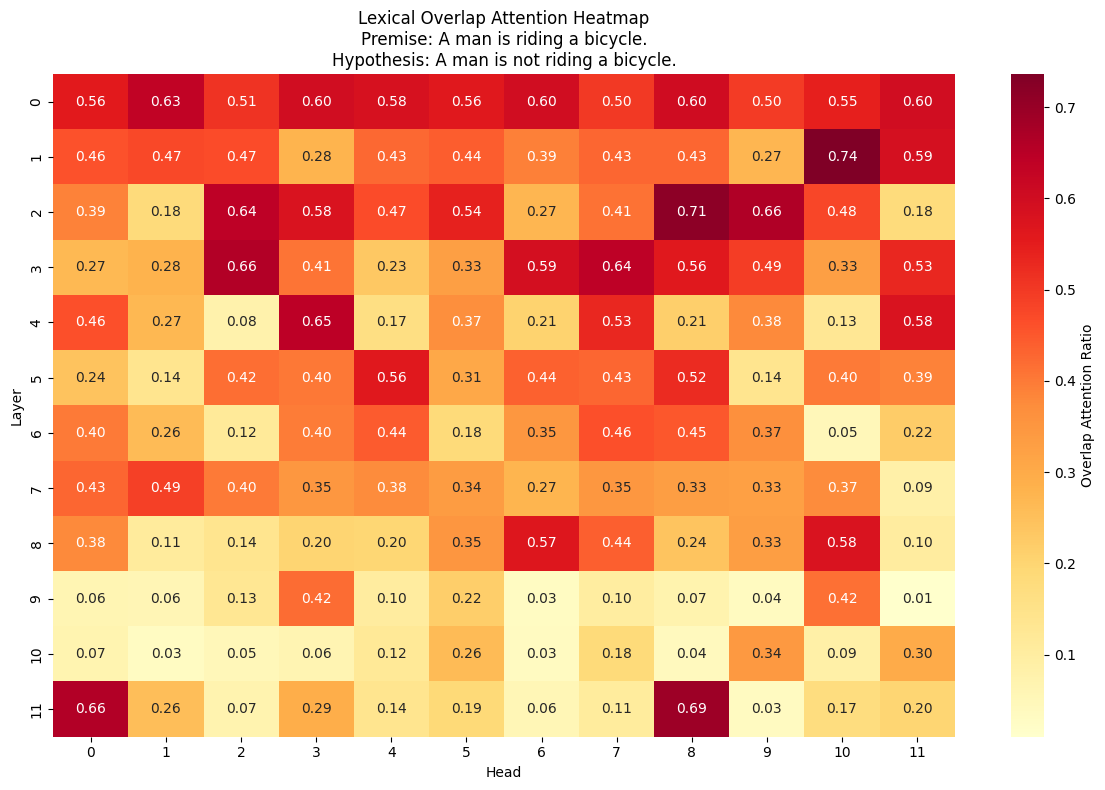

   layer  head  overlap_attention_ratio
0      0     0                 0.555460
1      0     1                 0.634540
2      0     2                 0.510018
3      0     3                 0.597665
4      0     4                 0.584568


In [ ]:
lex_examples = [
    #high lexical overlap - contradiction
    {
        'premise': "A man is riding a bicycle.",
        'hypothesis': "A man is not riding a bicycle.",
        'label': 1,
        'text': "A man is riding a bicycle. [SEP] A man is not riding a bicycle."
    },
    #low lexical overlap - entailment
    {
        'premise': "A boy is eating.",
        'hypothesis': "A child is having food.",
        'label': 0,
        'text': "A boy is eating. [SEP] A child is having food."
    }
]
df = visualisation.find_lexical_overlap_heads(
    premise=lex_examples[0]['premise'],
    hypothesis=lex_examples[0]['hypothesis']
)
print(df.head())

**COREF**

In [ ]:
coref_examples = [
    {
        "premise": "The lawyer met the doctor and he was upset.",
        "hypothesis_correct": "The lawyer was upset.",
        "hypothesis_incorrect": "The doctor was upset.",
        "pronoun": "he",
        "antecedent_correct": "lawyer",
        "antecedent_wrong": "doctor"
    },
    {
        "premise": "The sister scolded the brother because she was angry.",
        "hypothesis_correct": "The sister was angry.",
        "hypothesis_incorrect": "The brother was angry.",
        "pronoun": "she",
        "antecedent_correct": "sister",
        "antecedent_wrong": "brother"
    },
]

top_coref = visualisation.find_top_coref_heads(coref_examples)
print("Top 5 coreference heads:")
for score, layer, head in top_coref[:5]:
    print(f"Layer {layer}, Head {head}, Score={score:.4f}")



Top 5 coreference heads:
Layer 5, Head 10, Score=0.3064
Layer 1, Head 6, Score=0.1860
Layer 3, Head 5, Score=0.1242
Layer 0, Head 10, Score=0.0887
Layer 0, Head 6, Score=0.0443


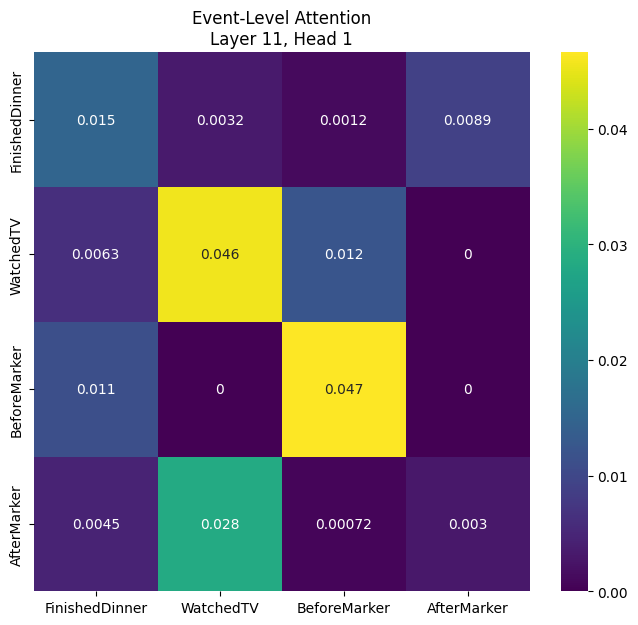

array([[0.01497763, 0.00319757, 0.00122598, 0.00894284],
       [0.00626168, 0.04565646, 0.01225705, 0.        ],
       [0.0112289 , 0.        , 0.04659577, 0.        ],
       [0.0044852 , 0.02829061, 0.00071649, 0.0029531 ]])

In [ ]:
temp_examples = [
    {
        "premise": "John finished dinner before he watched TV.",
        "hypothesis": "John watched TV after finishing dinner.",
        "label": "0"
    },
    {
        "premise": "John finished dinner before he watched TV.",
        "hypothesis": "John watched TV before finishing dinner.",
        "label": "1"
    },
]
event_spans = {
    "FinishedDinner": ["finished", "dinner"],
    "WatchedTV": ["watched", "TV"],
    "BeforeMarker": ["before"],
    "AfterMarker": ["after"]
}

p = "John finished dinner before he watched TV."
h = "John watched TV after finishing dinner."
visualisation.visualise_attention_head(
    p, h, layer=11, head=1,
    mode="events",
    event_spans=event_spans
)


**TEMPORAL ORDER**

events not found. Event1: [], Event2: [5, 8, 14, 17]
processed 49 examples

Bonferroni corrected threshold: 0.000347
Significant heads: 136 / 144
Percentage: 94.4%


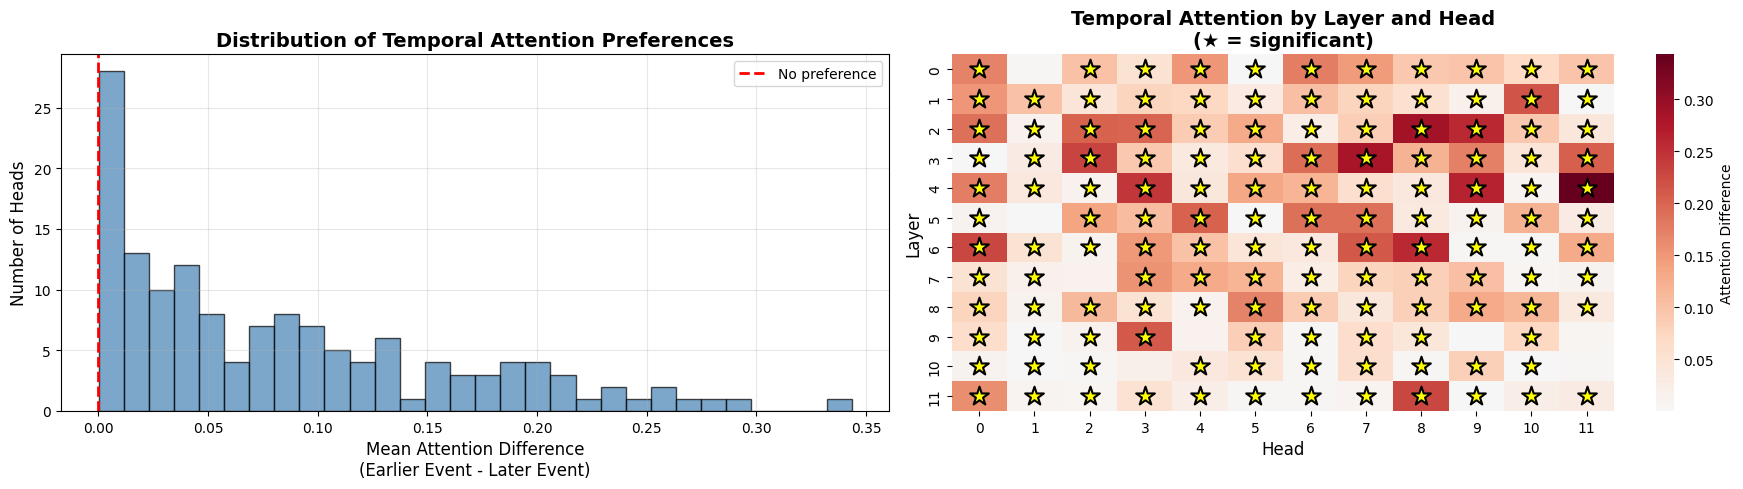


Top 10 heads for temporal reasoning:
1. Layer 4, Head 11: score = 0.3435
2. Layer 2, Head 8: score = 0.2872
3. Layer 3, Head 7: score = 0.2828
4. Layer 4, Head 9: score = 0.2656
5. Layer 2, Head 9: score = 0.2602
6. Layer 6, Head 8: score = 0.2578
7. Layer 4, Head 3: score = 0.2457
8. Layer 3, Head 2: score = 0.2309
9. Layer 6, Head 0: score = 0.2293
10. Layer 11, Head 8: score = 0.2289

Significant heads (p < 0.000347):
     layer  head  mean_difference       p_value
59       4    11         0.343457  8.860643e-17
32       2     8         0.287211  7.188975e-16
43       3     7         0.282775  5.909135e-20
57       4     9         0.265585  1.117508e-13
33       2     9         0.260195  3.631804e-19
..     ...   ...              ...           ...
109      9     1         0.002183  9.489244e-05
65       5     5         0.001521  4.291763e-07
23       1    11         0.001451  7.203091e-05
121     10     1         0.001250  2.297712e-04
36       3     0         0.000351  3.622085e-0

In [ ]:
temporal_examples = [
    # ============ "BEFORE" Examples (20) ============
    {
        "premise": "John finished dinner before he watched TV",
        "hypothesis": "John watched TV after finishing dinner",
        "event1_tokens": ["finished", "dinner"],
        "event2_tokens": ["watched", "TV"],
        "temporal_marker": "before"
    },
    {
        "premise": "She completed the report before the meeting started",
        "hypothesis": "The meeting started after she completed the report",
        "event1_tokens": ["completed", "report"],
        "event2_tokens": ["meeting", "started"],
        "temporal_marker": "before"
    },
    {
        "premise": "The lawyer met the doctor before he left the office",
        "hypothesis": "He left the office after meeting the doctor",
        "event1_tokens": ["met", "doctor"],
        "event2_tokens": ["left", "office"],
        "temporal_marker": "before"
    },
    {
        "premise": "He graduated from college before starting his job",
        "hypothesis": "He started his job after graduating from college",
        "event1_tokens": ["graduated", "college"],
        "event2_tokens": ["starting", "job"],
        "temporal_marker": "before"
    },
    {
        "premise": "They ate breakfast before leaving for work",
        "hypothesis": "They left for work after eating breakfast",
        "event1_tokens": ["ate", "breakfast"],
        "event2_tokens": ["leaving", "work"],
        "temporal_marker": "before"
    },
    {
        "premise": "She read the book before writing the review",
        "hypothesis": "She wrote the review after reading the book",
        "event1_tokens": ["read", "book"],
        "event2_tokens": ["writing", "review"],
        "temporal_marker": "before"
    },
    {
        "premise": "The children cleaned their room before going outside",
        "hypothesis": "The children went outside after cleaning their room",
        "event1_tokens": ["cleaned", "room"],
        "event2_tokens": ["going", "outside"],
        "temporal_marker": "before"
    },
    {
        "premise": "He checked his email before attending the conference",
        "hypothesis": "He attended the conference after checking his email",
        "event1_tokens": ["checked", "email"],
        "event2_tokens": ["attending", "conference"],
        "temporal_marker": "before"
    },
    {
        "premise": "The team finished practice before the game began",
        "hypothesis": "The game began after the team finished practice",
        "event1_tokens": ["finished", "practice"],
        "event2_tokens": ["game", "began"],
        "temporal_marker": "before"
    },
    {
        "premise": "She studied the material before taking the exam",
        "hypothesis": "She took the exam after studying the material",
        "event1_tokens": ["studied", "material"],
        "event2_tokens": ["taking", "exam"],
        "temporal_marker": "before"
    },
    {
        "premise": "He washed his hands before eating lunch",
        "hypothesis": "He ate lunch after washing his hands",
        "event1_tokens": ["washed", "hands"],
        "event2_tokens": ["eating", "lunch"],
        "temporal_marker": "before"
    },
    {
        "premise": "The company announced earnings before the market closed",
        "hypothesis": "The market closed after the company announced earnings",
        "event1_tokens": ["announced", "earnings"],
        "event2_tokens": ["market", "closed"],
        "temporal_marker": "before"
    },
    {
        "premise": "She packed her bags before calling a taxi",
        "hypothesis": "She called a taxi after packing her bags",
        "event1_tokens": ["packed", "bags"],
        "event2_tokens": ["calling", "taxi"],
        "temporal_marker": "before"
    },
    {
        "premise": "The professor graded exams before posting results",
        "hypothesis": "The professor posted results after grading exams",
        "event1_tokens": ["graded", "exams"],
        "event2_tokens": ["posting", "results"],
        "temporal_marker": "before"
    },
    {
        "premise": "He saved the document before closing the application",
        "hypothesis": "He closed the application after saving the document",
        "event1_tokens": ["saved", "document"],
        "event2_tokens": ["closing", "application"],
        "temporal_marker": "before"
    },
    {
        "premise": "They discussed the plan before making a decision",
        "hypothesis": "They made a decision after discussing the plan",
        "event1_tokens": ["discussed", "plan"],
        "event2_tokens": ["making", "decision"],
        "temporal_marker": "before"
    },
    {
        "premise": "She warmed up before running the marathon",
        "hypothesis": "She ran the marathon after warming up",
        "event1_tokens": ["warmed", "up"],
        "event2_tokens": ["running", "marathon"],
        "temporal_marker": "before"
    },
    {
        "premise": "The chef prepared ingredients before cooking the meal",
        "hypothesis": "The chef cooked the meal after preparing ingredients",
        "event1_tokens": ["prepared", "ingredients"],
        "event2_tokens": ["cooking", "meal"],
        "temporal_marker": "before"
    },
    {
        "premise": "He locked the door before leaving the house",
        "hypothesis": "He left the house after locking the door",
        "event1_tokens": ["locked", "door"],
        "event2_tokens": ["leaving", "house"],
        "temporal_marker": "before"
    },
    {
        "premise": "She rehearsed her speech before presenting to the board",
        "hypothesis": "She presented to the board after rehearsing her speech",
        "event1_tokens": ["rehearsed", "speech"],
        "event2_tokens": ["presenting", "board"],
        "temporal_marker": "before"
    },
    
    # ============ "AFTER" Examples (20) ============
    {
        "premise": "The storm hit after everyone evacuated",
        "hypothesis": "Everyone evacuated before the storm hit",
        "event1_tokens": ["evacuated"],
        "event2_tokens": ["storm", "hit"],
        "temporal_marker": "after"
    },
    {
        "premise": "He called his mom after arriving home",
        "hypothesis": "He arrived home before calling his mom",
        "event1_tokens": ["arriving", "home"],
        "event2_tokens": ["called", "mom"],
        "temporal_marker": "after"
    },
    {
        "premise": "They celebrated after winning the championship",
        "hypothesis": "They won the championship before celebrating",
        "event1_tokens": ["winning", "championship"],
        "event2_tokens": ["celebrated"],
        "temporal_marker": "after"
    },
    {
        "premise": "She felt relieved after submitting the application",
        "hypothesis": "She submitted the application before feeling relieved",
        "event1_tokens": ["submitting", "application"],
        "event2_tokens": ["felt", "relieved"],
        "temporal_marker": "after"
    },
    {
        "premise": "The audience clapped after the performance ended",
        "hypothesis": "The performance ended before the audience clapped",
        "event1_tokens": ["performance", "ended"],
        "event2_tokens": ["audience", "clapped"],
        "temporal_marker": "after"
    },
    {
        "premise": "He rested after completing the workout",
        "hypothesis": "He completed the workout before resting",
        "event1_tokens": ["completing", "workout"],
        "event2_tokens": ["rested"],
        "temporal_marker": "after"
    },
    {
        "premise": "The plants grew after receiving water",
        "hypothesis": "The plants received water before growing",
        "event1_tokens": ["receiving", "water"],
        "event2_tokens": ["plants", "grew"],
        "temporal_marker": "after"
    },
    {
        "premise": "She smiled after hearing the good news",
        "hypothesis": "She heard the good news before smiling",
        "event1_tokens": ["hearing", "news"],
        "event2_tokens": ["smiled"],
        "temporal_marker": "after"
    },
    {
        "premise": "The teacher distributed papers after explaining the instructions",
        "hypothesis": "The teacher explained the instructions before distributing papers",
        "event1_tokens": ["explaining", "instructions"],
        "event2_tokens": ["distributed", "papers"],
        "temporal_marker": "after"
    },
    {
        "premise": "He became famous after releasing the album",
        "hypothesis": "He released the album before becoming famous",
        "event1_tokens": ["releasing", "album"],
        "event2_tokens": ["became", "famous"],
        "temporal_marker": "after"
    },
    {
        "premise": "The baby fell asleep after drinking milk",
        "hypothesis": "The baby drank milk before falling asleep",
        "event1_tokens": ["drinking", "milk"],
        "event2_tokens": ["fell", "asleep"],
        "temporal_marker": "after"
    },
    {
        "premise": "Stock prices dropped after the announcement was made",
        "hypothesis": "The announcement was made before stock prices dropped",
        "event1_tokens": ["announcement", "made"],
        "event2_tokens": ["prices", "dropped"],
        "temporal_marker": "after"
    },
    {
        "premise": "She slept well after solving the problem",
        "hypothesis": "She solved the problem before sleeping well",
        "event1_tokens": ["solving", "problem"],
        "event2_tokens": ["slept", "well"],
        "temporal_marker": "after"
    },
    {
        "premise": "The city recovered after rebuilding infrastructure",
        "hypothesis": "The city rebuilt infrastructure before recovering",
        "event1_tokens": ["rebuilding", "infrastructure"],
        "event2_tokens": ["city", "recovered"],
        "temporal_marker": "after"
    },
    {
        "premise": "He understood the concept after reading the explanation",
        "hypothesis": "He read the explanation before understanding the concept",
        "event1_tokens": ["reading", "explanation"],
        "event2_tokens": ["understood", "concept"],
        "temporal_marker": "after"
    },
    {
        "premise": "The lights turned on after she flipped the switch",
        "hypothesis": "She flipped the switch before the lights turned on",
        "event1_tokens": ["flipped", "switch"],
        "event2_tokens": ["lights", "turned"],
        "temporal_marker": "after"
    },
    {
        "premise": "They left the restaurant after paying the bill",
        "hypothesis": "They paid the bill before leaving the restaurant",
        "event1_tokens": ["paying", "bill"],
        "event2_tokens": ["left", "restaurant"],
        "temporal_marker": "after"
    },
    {
        "premise": "She started exercising after consulting her doctor",
        "hypothesis": "She consulted her doctor before starting to exercise",
        "event1_tokens": ["consulting", "doctor"],
        "event2_tokens": ["started", "exercising"],
        "temporal_marker": "after"
    },
    {
        "premise": "The fire spread after igniting the dry grass",
        "hypothesis": "The dry grass ignited before the fire spread",
        "event1_tokens": ["igniting", "grass"],
        "event2_tokens": ["fire", "spread"],
        "temporal_marker": "after"
    },
    {
        "premise": "He changed careers after discovering his passion",
        "hypothesis": "He discovered his passion before changing careers",
        "event1_tokens": ["discovering", "passion"],
        "event2_tokens": ["changed", "careers"],
        "temporal_marker": "after"
    },
    
    # ============ "WHILE" Examples (10) ============
    {
        "premise": "She listened to music while studying for exams",
        "hypothesis": "She studied for exams and listened to music simultaneously",
        "event1_tokens": ["listened", "music"],
        "event2_tokens": ["studying", "exams"],
        "temporal_marker": "while"
    },
    {
        "premise": "He talked on the phone while driving to work",
        "hypothesis": "He drove to work and talked on the phone at the same time",
        "event1_tokens": ["talked", "phone"],
        "event2_tokens": ["driving", "work"],
        "temporal_marker": "while"
    },
    {
        "premise": "The baby slept while his mother cooked dinner",
        "hypothesis": "His mother cooked dinner during the baby's sleep",
        "event1_tokens": ["baby", "slept"],
        "event2_tokens": ["mother", "cooked"],
        "temporal_marker": "while"
    },
    {
        "premise": "They watched TV while eating popcorn",
        "hypothesis": "They ate popcorn and watched TV simultaneously",
        "event1_tokens": ["watched", "TV"],
        "event2_tokens": ["eating", "popcorn"],
        "temporal_marker": "while"
    },
    {
        "premise": "She took notes while attending the lecture",
        "hypothesis": "She attended the lecture and took notes at the same time",
        "event1_tokens": ["took", "notes"],
        "event2_tokens": ["attending", "lecture"],
        "temporal_marker": "while"
    },
    {
        "premise": "The dog barked while the mailman approached",
        "hypothesis": "The mailman approached during the dog's barking",
        "event1_tokens": ["dog", "barked"],
        "event2_tokens": ["mailman", "approached"],
        "temporal_marker": "while"
    },
    {
        "premise": "He exercised while listening to a podcast",
        "hypothesis": "He listened to a podcast and exercised simultaneously",
        "event1_tokens": ["exercised"],
        "event2_tokens": ["listening", "podcast"],
        "temporal_marker": "while"
    },
    {
        "premise": "The children played while their parents talked",
        "hypothesis": "The parents talked during the children's playtime",
        "event1_tokens": ["children", "played"],
        "event2_tokens": ["parents", "talked"],
        "temporal_marker": "while"
    },
    {
        "premise": "She drank coffee while reading the newspaper",
        "hypothesis": "She read the newspaper and drank coffee at the same time",
        "event1_tokens": ["drank", "coffee"],
        "event2_tokens": ["reading", "newspaper"],
        "temporal_marker": "while"
    },
    {
        "premise": "It rained while we walked through the park",
        "hypothesis": "We walked through the park during the rain",
        "event1_tokens": ["rained"],
        "event2_tokens": ["walked", "park"],
        "temporal_marker": "while"
    },
]

# Initialize your visualizer (assuming you have model and tokenizer)

# Run the analysis
results_df, top_heads = visualisation.find_top_temporal_heads(temporal_examples)

# Print top 10 heads
print("\nTop 10 heads for temporal reasoning:")
for i, (score, layer, head) in enumerate(top_heads[:10], 1):
    print(f"{i}. Layer {layer}, Head {head}: score = {score:.4f}")

# Get significant heads only
significant = results_df[results_df['significant_bonferroni']].sort_values('mean_difference', ascending=False)
print(f"\nSignificant heads (p < {0.05/len(results_df):.6f}):")
print(significant[['layer', 'head', 'mean_difference', 'p_value']])

  # placeholder


# Add these methods to your NLI_visualisation class

**NEGATION**

Processed 50 examples

Bonferroni corrected threshold: 0.000347
Attention TO negation - Significant heads: 27 / 144
Percentage: 18.8%
Attention FROM negation - Significant heads: 0 / 144
Percentage: 0.0%


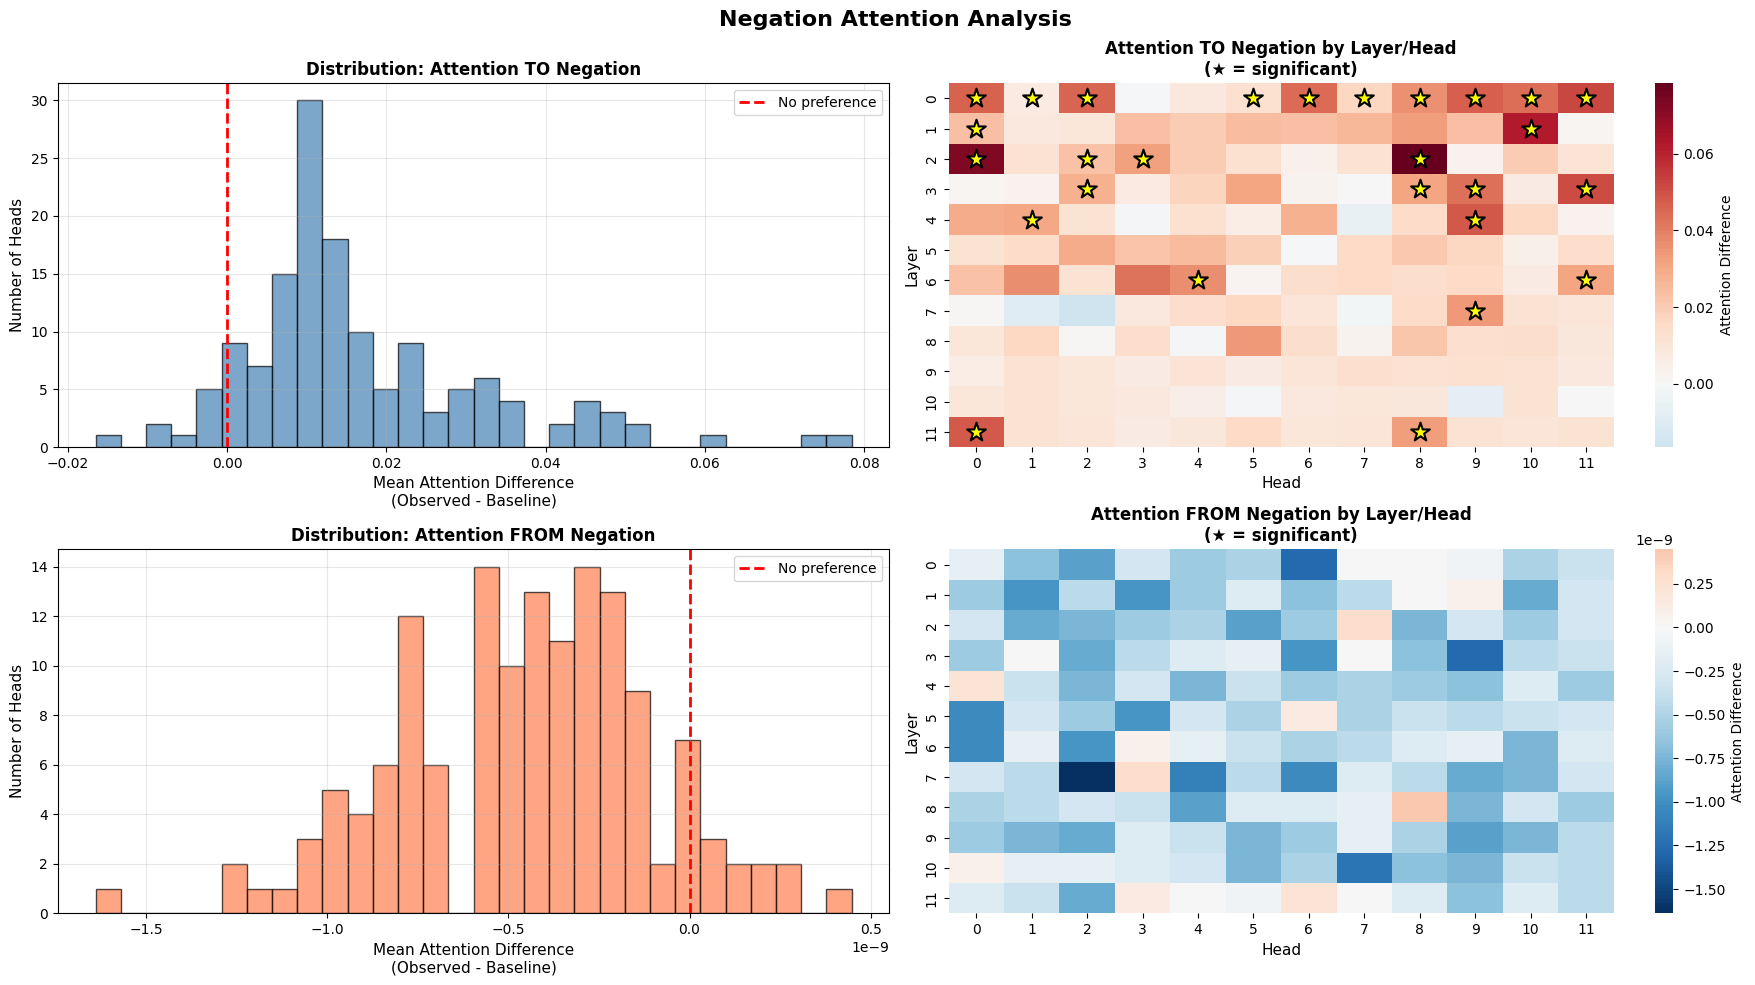

In [ ]:
negation_examples = [
    # ============ "NOT" Examples (15) ============
    {
        "premise": "The movie was not entertaining",
        "hypothesis": "The movie was boring"
    },
    {
        "premise": "The food is not spicy",
        "hypothesis": "The food is mild"
    },
    {
        "premise": "He is not guilty of the crime",
        "hypothesis": "He is innocent"
    },
    {
        "premise": "The weather is not cold today",
        "hypothesis": "The weather is warm today"
    },
    {
        "premise": "She is not satisfied with the results",
        "hypothesis": "She is disappointed with the results"
    },
    {
        "premise": "The book is not interesting",
        "hypothesis": "The book is dull"
    },
    {
        "premise": "The exam was not difficult",
        "hypothesis": "The exam was easy"
    },
    {
        "premise": "The room is not clean",
        "hypothesis": "The room is dirty"
    },
    {
        "premise": "The solution is not simple",
        "hypothesis": "The solution is complex"
    },
    {
        "premise": "The price is not expensive",
        "hypothesis": "The price is affordable"
    },
    {
        "premise": "The journey was not short",
        "hypothesis": "The journey was long"
    },
    {
        "premise": "The test is not easy",
        "hypothesis": "The test is challenging"
    },
    {
        "premise": "The coffee is not hot",
        "hypothesis": "The coffee is lukewarm"
    },
    {
        "premise": "The lecture was not boring",
        "hypothesis": "The lecture was engaging"
    },
    {
        "premise": "The decision was not wise",
        "hypothesis": "The decision was foolish"
    },
    
    # ============ "DIDN'T / DON'T" Examples (15) ============
    {
        "premise": "He didn't attend the meeting",
        "hypothesis": "He was absent from the meeting"
    },
    {
        "premise": "She didn't finish the assignment",
        "hypothesis": "The assignment is incomplete"
    },
    {
        "premise": "They didn't win the game",
        "hypothesis": "They lost the game"
    },
    {
        "premise": "He didn't pass the exam",
        "hypothesis": "He failed the exam"
    },
    {
        "premise": "She didn't accept the offer",
        "hypothesis": "She rejected the offer"
    },
    {
        "premise": "I don't like vegetables",
        "hypothesis": "I dislike vegetables"
    },
    {
        "premise": "They don't agree with the proposal",
        "hypothesis": "They oppose the proposal"
    },
    {
        "premise": "He doesn't understand the concept",
        "hypothesis": "He is confused about the concept"
    },
    {
        "premise": "She doesn't have any money",
        "hypothesis": "She is broke"
    },
    {
        "premise": "The car didn't start this morning",
        "hypothesis": "The car broke down this morning"
    },
    {
        "premise": "He didn't receive the package",
        "hypothesis": "The package never arrived"
    },
    {
        "premise": "She doesn't eat meat",
        "hypothesis": "She is vegetarian"
    },
    {
        "premise": "They didn't respond to the email",
        "hypothesis": "They ignored the email"
    },
    {
        "premise": "He doesn't believe the story",
        "hypothesis": "He doubts the story"
    },
    {
        "premise": "The plan didn't work",
        "hypothesis": "The plan failed"
    },
    
    # ============ "NEVER" Examples (10) ============
    {
        "premise": "She never drinks coffee",
        "hypothesis": "She avoids coffee"
    },
    {
        "premise": "He never tells lies",
        "hypothesis": "He is always honest"
    },
    {
        "premise": "They never arrive on time",
        "hypothesis": "They are always late"
    },
    {
        "premise": "I never eat fast food",
        "hypothesis": "I avoid fast food"
    },
    {
        "premise": "She never gives up",
        "hypothesis": "She is persistent"
    },
    {
        "premise": "He never forgets a face",
        "hypothesis": "He has excellent memory for faces"
    },
    {
        "premise": "The train never runs late",
        "hypothesis": "The train is always punctual"
    },
    {
        "premise": "She never breaks promises",
        "hypothesis": "She is reliable"
    },
    {
        "premise": "He never loses his temper",
        "hypothesis": "He is patient"
    },
    {
        "premise": "They never waste food",
        "hypothesis": "They are frugal with food"
    },
    
    # ============ "NO" / "NONE" / "NOTHING" Examples (10) ============
    {
        "premise": "There is no evidence of fraud",
        "hypothesis": "The case lacks evidence of fraud"
    },
    {
        "premise": "He has no experience in marketing",
        "hypothesis": "He is inexperienced in marketing"
    },
    {
        "premise": "There are no seats available",
        "hypothesis": "All seats are occupied"
    },
    {
        "premise": "She showed no emotion",
        "hypothesis": "She remained expressionless"
    },
    {
        "premise": "There is no cure for this disease",
        "hypothesis": "This disease is incurable"
    },
    {
        "premise": "He made no attempt to help",
        "hypothesis": "He refused to help"
    },
    {
        "premise": "None of the students passed the test",
        "hypothesis": "All students failed the test"
    },
    {
        "premise": "There is nothing in the refrigerator",
        "hypothesis": "The refrigerator is empty"
    },
    {
        "premise": "Nothing can stop him now",
        "hypothesis": "He is unstoppable"
    },
    {
        "premise": "None of the answers were correct",
        "hypothesis": "All answers were wrong"
    },
]

results_to, results_from, top_to, top_from = visualisation.find_top_negation_heads(negation_examples)

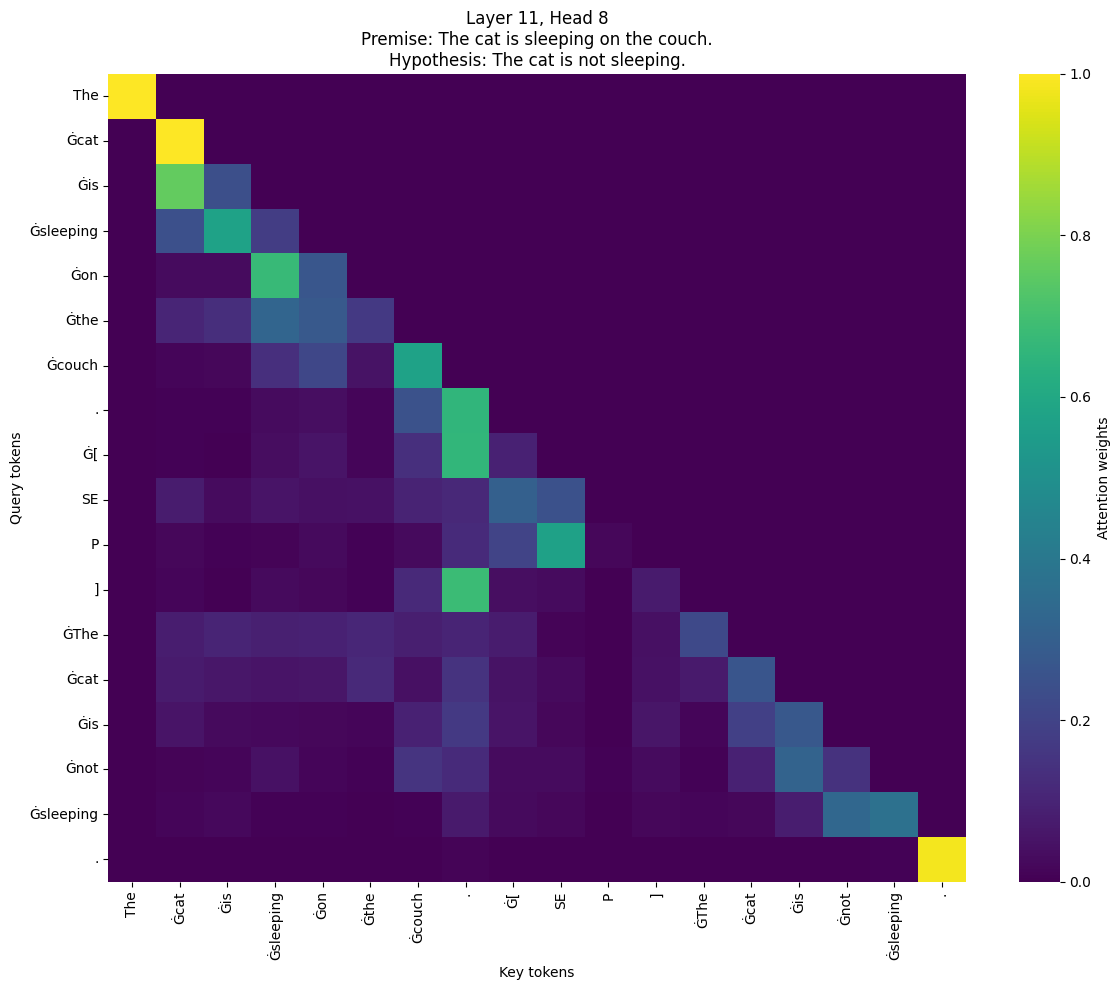

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [2.06336874e-04, 9.99793708e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [2.13470048e-05, 7.60348976e-01, 2.39629656e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [7.142

In [ ]:
visualisation.visualise_attention_head(
    premise="The cat is sleeping on the couch.",
    hypothesis="The cat is not sleeping.",
    layer=11,
    head=8,mode="tokens"
)